In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cb25d.batch import run_batch_simulation
from cb25d.compare_gamma_original import run_gamma_comparison_original
from cb25d.interactive import run_interactive_simulation
from cb25d.notebook import init, savefig
from cb25d.simulation_impl_original import (
    SimulationImplOriginal,
    SimulationRecorderOriginal,
    SimulationRendererOriginal,
    generate_initial_conditions,
)

init()

pygame-ce 2.5.6 (SDL 2.32.10, Python 3.13.9)


In [2]:
run_interactive_simulation(
    SimulationImplOriginal(
        c_eta=0.8,
        c_gamma_ali=0.6,
        c_gamma_att=0.6,
        c_gamma_rand=0.2,
        c_k=1,
        c_l_ali=3,
        c_tau_0=0.8,
        **generate_initial_conditions(
            seed=0,
            n=100,
            l_att=3,
            tau_n_mean=1,
            tau_n_std=1,
        ),
    ),
    SimulationRendererOriginal(
        pos_size=2 / 4,
        pos_color=(0, 255, 0),
        dir_len=5 / 4,
        dir_width=1 / 4,
        dir_color=(50, 255, 50),
    ),
    scale=2**-5,
)

In [ ]:
run_interactive_simulation(
    SimulationImplOriginal(
        c_eta=0.8,
        c_gamma_ali=0.2,
        c_gamma_att=0.37,
        c_gamma_rand=0.2,
        c_k=1,
        c_l_ali=3,
        c_tau_0=0.8,
        **generate_initial_conditions(
            seed=1,
            n=100,
            l_att=3,
            tau_n_mean=1,
            tau_n_std=1,
        ),
    ),
    SimulationRendererOriginal(
        pos_size=2 / 8,
        pos_color=(0, 255, 0),
        dir_len=5 / 8,
        dir_width=1 / 8,
        dir_color=(50, 255, 50),
    ),
    scale=2**-5,
)


In [ ]:
run_batch_simulation(
    SimulationImplOriginal(
        c_eta=0.8,
        c_gamma_ali=0.2,
        c_gamma_att=0.37,
        c_gamma_rand=0.2,
        c_k=1,
        c_l_ali=3,
        c_tau_0=0.8,
        **generate_initial_conditions(
            seed=1,
            n=100,
            l_att=3,
            tau_n_mean=1,
            tau_n_std=1,
        ),
    ),
    rec := SimulationRecorderOriginal(skip_first_n=1000),
    steps=2000,
)
print(rec.dispersion)
print(rec.polarization)

In [2]:
att_vals = np.arange(0, 0.6, 0.05)
ali_vals = np.arange(0, 1.2, 0.1)
statistics = run_gamma_comparison_original(
    seed=0,
    att_vals=att_vals,
    ali_vals=ali_vals,
    create_initial_state=lambda att, ali, seed: SimulationImplOriginal(
        c_eta=0.8,
        c_gamma_ali=ali,
        c_gamma_att=att,
        c_gamma_rand=0.2,
        c_k=1,
        c_l_ali=3,
        c_tau_0=0.8,
        **generate_initial_conditions(
            seed=seed,
            n=100,
            l_att=3,
            tau_n_mean=1,
            tau_n_std=1,
        ),
    ),
    runs_per_config=20,
    steps_per_run=2000 * 100,
)

  0%|          | 0/2880 [00:00<?, ?it/s]

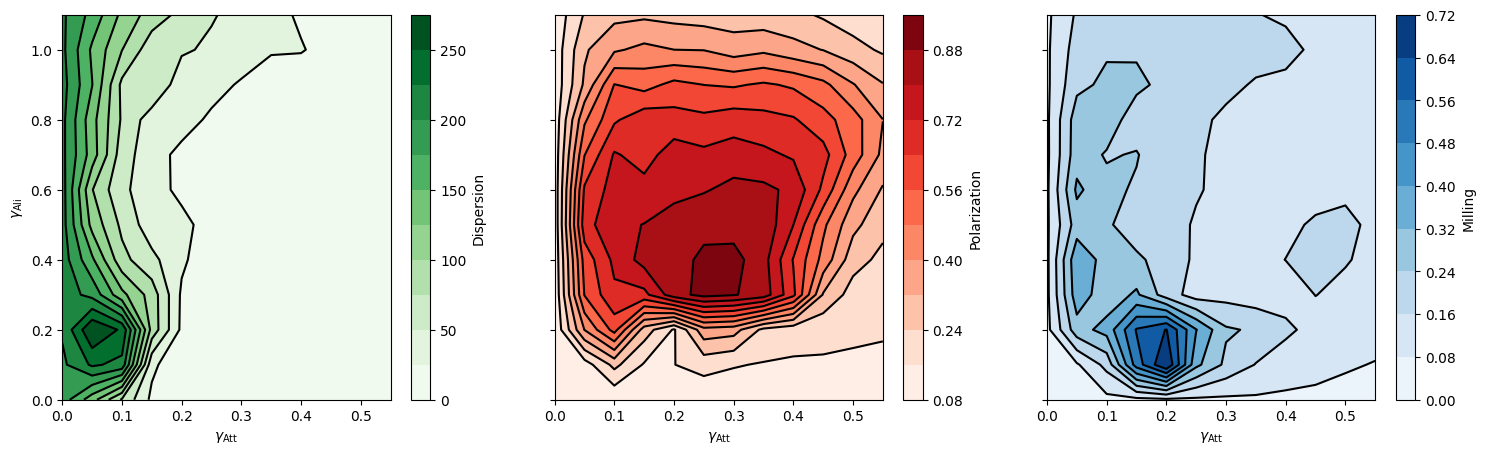

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

ax1.set_ylabel(r"$\gamma_\text{Ali}$")

ax1.contour(att_vals, ali_vals, statistics[:, :, 0].T, levels=10, colors="k")
cntr1 = ax1.contourf(
    att_vals, ali_vals, statistics[:, :, 0].T, levels=10, cmap="Greens"
)
ax1.set_xlabel(r"$\gamma_\text{Att}$")
cbar1 = fig.colorbar(cntr1, ax=ax1)
cbar1.set_label("Dispersion")

ax2.contour(att_vals, ali_vals, statistics[:, :, 1].T, levels=10, colors="k")
cntr2 = ax2.contourf(att_vals, ali_vals, statistics[:, :, 1].T, levels=10, cmap="Reds")
ax2.set_xlabel(r"$\gamma_\text{Att}$")
cbar2 = fig.colorbar(cntr2, ax=ax2)
cbar2.set_label("Polarization")

ax3.contour(att_vals, ali_vals, statistics[:, :, 2].T, levels=10, colors="k")
cntr3 = ax3.contourf(att_vals, ali_vals, statistics[:, :, 2].T, levels=10, cmap="Blues")
ax3.set_xlabel(r"$\gamma_\text{Att}$")
cbar3 = fig.colorbar(cntr3, ax=ax3)
cbar3.set_label("Milling")

savefig(fig, "fig/wip_statistics.pdf")